<a href="https://colab.research.google.com/github/AnupamaRajkumar/PyTorchTutorials/blob/main/ImageRecognitionUsingMNISTUsingLeNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Multi-class classification : Softmax function

In [1]:
!pip3 install torch

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

This is needed to counter the HTTP 503 error

In [4]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2021-03-21 06:10:38--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-03-21 06:10:38--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [         <=>        ]  33.20M  18.9MB/s    in 1.8s    

2021-03-21 06:10:40 (18.9 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [5]:
root_dir = './'
datasets.MNIST(root=root_dir,download=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train

In [6]:
transform = transforms.Compose([transforms.ToTensor(), 
                                #first argument specifies the mean, second argument specifies the stddev to create a range from -1 to 1
                                transforms.Normalize((0.5,), (0.5,))])
#training
training_dataset = datasets.MNIST(root=root_dir, train=True, download=True, transform=transform)
#validation
validation_dataset = datasets.MNIST(root = root_dir, train=False, download=True, transform=transform)

Training data loader

In [7]:
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)

Validation data loader

In [8]:
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False) 

Converting tensors to numpy so as to plot it\
To get numpy() from tensor, use detach() function

Why we use detach()?\
torch.tensors has an additional layer for storing the computational graph leading to associated n-dimesional matrix. torch.tensors() are designed to be used with gradient descent optimisation and they hold both the tensors with numeric values and computational graph leading to these values. The computational graph is then used to compute the derivative of the loss function wrt to each of the independent variables to compute the loss.\
np.ndarray does not have this "computational graph" and hence when converting a tensor to numpy array, detach() is used to remove this computational graph\
https://stackoverflow.com/questions/63582590/why-do-we-call-detach-before-calling-numpy-on-a-pytorch-tensor

In [9]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0) #shape 28 x 28 x 1
  #de-normalisation - multiply by std and add mean
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

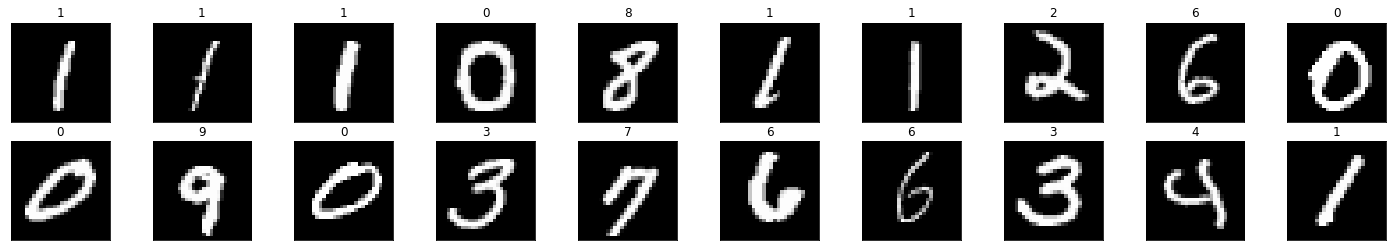

In [10]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(labels[idx].item())

nn.Sequential and nn.Module\
**nn.Module**: This is the main building block, it defines base class for all the neural network and you MUST subclass it. When using nn.Module, we must write our own forward() method. This allows us to define our own model in a functional way\
**nn.Sequential**: Sequential is a container of Modules that can be stacked together and run at the same time 



https://towardsdatascience.com/pytorch-how-and-when-to-use-module-sequential-modulelist-and-moduledict-7a54597b5f17


This model tends to overfit, hence we try to use CNN instead and check if the performance improves

In [11]:
class Classifier(nn.Module):
  def __init__(self, d_in, h1, h2, d_out):
    super().__init__()
    self.linear1 = nn.Linear(d_in, h1)
    self.linear2 = nn.Linear(h1, h2)
    self.linear3 = nn.Linear(h2, d_out)

  def forward(self, x):
    H1 = F.relu(self.linear1(x))
    H2 = F.relu(self.linear2(H1))
    #we can omit softmax here since we will use crossentropy as loss criterion
    #and it's implementation in pytorch already implements softmax
    Y  = self.linear3(H2)
    return Y


Convolutional Neural Network : LeNet

How did we arrive ar 4x4x50?\
1. i/p image dims = 28x28x1
2. first  2d conv with kernel of size 5 and stride 1 and 20 o/p channels = (28-5+1) = 24x24x20
3. max pooling with kernel of size 2 and 20 o/p channels = (24/2) = 12x12x20
4. second 2d conv with kernel of size 5 and stride 1 and 50 o/p channnels = (12-5+1) = 8x8x50
5. max pooing with kernel of size 2 and 50 o/p channels = (8/2) = 4x4x50
6. first fully connected layer = 4x4x50, linearised



In [12]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 20, 5, 1)           #number of input channels, number of output channels, kernel size, stride length
    self.conv2 = nn.Conv2d(20, 50, 5, 1)
    self.fc1 = nn.Linear(4*4*50, 500)
    self.fc2 = nn.Linear(500, 10)
    self.drop1 = nn.Dropout(0.5)                  #dropout to prevent overfitting

  def forward(self, x):
    L1 = F.relu(self.conv1(x))
    P1 = F.max_pool2d(L1, 2, 2)
    L2 = F.relu(self.conv2(P1))
    P2 = F.max_pool2d(L2, 2, 2)
    fi = P2.view(-1, 4*4*50)
    f1 = F.relu(self.fc1(fi))
    d1 = self.drop1(f1)
    #we can omit softmax here since we will use crossentropy as loss criterion
    #and it's implementation in pytorch already implements softmax
    f2  = self.fc2(d1)
    return f2

In [13]:
model = LeNet().to(device) 
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [15]:
epochs = 15
losses = []
accuracy = []
val_losses = []
val_accuracies = []

for e in range(epochs):
  running_loss = 0.0
  running_accuracy = 0.0
  val_loss = 0.0
  val_accuracy = 0.0

  for images, labels in training_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)   
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_accuracy += torch.sum(preds == labels.data)
    running_loss += loss.item() 

  else:
    with torch.no_grad():       #because we dont have to perform gradients for validation set
      for val_images, val_labels in validation_loader:
        val_images = val_images.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_images)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_accuracy += torch.sum(val_preds == val_labels.data)
        val_loss += val_loss.item() 
    #metrics for training data
    epoch_loss = running_loss/len(training_loader)
    epoch_accuracy = running_accuracy.float()/len(training_loader)
    losses.append(epoch_loss)
    accuracy.append(epoch_accuracy)
    #metrics for validation data
    val_epoch_loss = val_loss/len(validation_loader)
    val_epoch_accuracy = val_accuracy.float()/len(validation_loader)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)
    #print the training and validation metrics
    print("epoch:", e+1)
    print('training loss: {:.6f}, acc {:.6f}'.format(epoch_loss, epoch_accuracy.item()))
    print('validation loss: {:.6f}, acc {:.6f}'.format(val_epoch_loss, val_epoch_accuracy.item()))


epoch: 1
training loss: 0.579368, acc 84.741669
validation loss: 0.004914, acc 94.610001
epoch: 2
training loss: 0.149021, acc 95.653336
validation loss: 0.003493, acc 96.949997
epoch: 3
training loss: 0.100730, acc 96.963333
validation loss: 0.001792, acc 97.610001
epoch: 4
training loss: 0.080078, acc 97.556671
validation loss: 0.001605, acc 97.989998
epoch: 5
training loss: 0.065622, acc 98.006668
validation loss: 0.000729, acc 98.180000
epoch: 6
training loss: 0.057008, acc 98.268333
validation loss: 0.001147, acc 98.519997
epoch: 7
training loss: 0.049920, acc 98.486671
validation loss: 0.000488, acc 98.559998
epoch: 8
training loss: 0.045267, acc 98.663338
validation loss: 0.000403, acc 98.669998
epoch: 9
training loss: 0.041394, acc 98.723335
validation loss: 0.000141, acc 98.829994
epoch: 10
training loss: 0.036578, acc 98.866669
validation loss: 0.000596, acc 98.939995
epoch: 11
training loss: 0.034752, acc 98.950005
validation loss: 0.000375, acc 98.699997
epoch: 12
training 

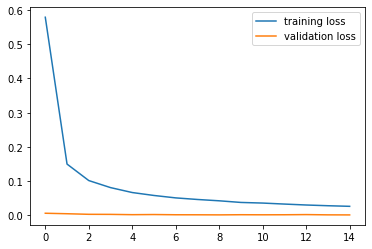

In [18]:
plt.plot(losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

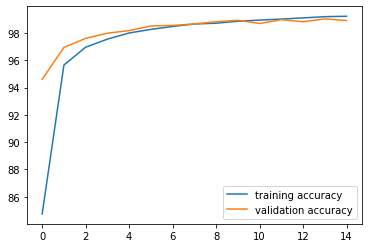

In [19]:
plt.plot(accuracy, label='training accuracy')
plt.plot(val_accuracies, label = 'validation accuracy')
plt.legend()